In [1]:
%pylab inline
import pandas as pd
import scipy.io.wavfile as wavefile
import scipy.signal
import soundfile
import io
import hashlib
import librosa

Populating the interactive namespace from numpy and matplotlib


In [2]:
def normalize_wav(arr,trunc=False, always_norm=False):
    if trunc and len(arr)>16000:
        arr=arr[:16000]
    arr=arr-np.mean(arr)
    if len(arr)<16000:
        m=(16000-len(arr))
        arr=np.concatenate([np.zeros([int(m/2)]), arr, np.zeros(m-int(m/2))])
    assert len(arr)==16000
    max_v=np.max(np.abs(arr))+1e-8
    if max_v>1 or always_norm: 
        arr=arr/max_v
    return arr.astype(np.float32)
def read_file(fname,trunc=False):
    arr=wavefile.read(fname)[1].astype(np.float32)
    return normalize_wav(arr,trunc=trunc)
def read_traininfo():
    traininfo=pd.read_csv("../info/train_info.csv")
    print traininfo.shape 
    traininfo=traininfo.groupby("sha256").first().reset_index()
    print traininfo.shape
    traininfo=traininfo[traininfo['clear']==1]
    print traininfo.shape
    display(traininfo['label'].value_counts().to_frame().T)
    return traininfo

In [3]:
traininfo=read_traininfo()

(64721, 11)
(64300, 11)
(64133, 11)


unknown    no  stop   yes    on  down    go  right  left   off    up
label    40747  2354  2354  2349  2343  2343  2339   2338  2331  2325  2310

In [4]:
import os
class NoiseGenerator(object):
    def __init__(self,noise_path="../input/train/audio/_background_noise_/",silence_ratio=0.01):
        filenames = [u for u in os.listdir(noise_path) if u.endswith('.wav')]
        assert (len(filenames)>0)
        print "loaded {} noise files".format(len(filenames))
        self.data={u:soundfile.read(noise_path+"/"+u)[0] for u in filenames}
        self.filenames=filenames
    def generate_single(self,always_norm):
        i=random.choice(self.filenames,1)[0]
        x=self.data[i]
        j=int(np.random.random()*(len(x)-2000))
        return normalize_wav(x[j:j+16000],always_norm=always_norm)
    def generate(self,always_norm=False):
        rnd=np.random.random()
        if rnd<0.2:
            noise= self.generate_single(always_norm)
        elif rnd<0.8:
            a,b=self.generate_single(always_norm),self.generate_single(always_norm)
            p=np.random.random()
            noise=p*a+(1-p)*b
        else:
            a,b,c=self.generate_single(always_norm),self.generate_single(always_norm),self.generate_single(always_norm)
            p=np.random.random(3)
            p=np.exp(p)
            p=p/np.sum(p)
            noise=a*p[0]+b*p[1]+c*p[2]
        noise=normalize_wav(noise,always_norm=always_norm)
        rnd=np.random.random()
        if rnd>0.66:
            noise[:int(np.random.random()*len(noise))]=0
        elif rnd<0.33:
            noise[int(np.random.random()*len(noise)):]=0
        return noise.astype(np.float32)
        

In [5]:
if 0:
    for k,u in a.data.items():
        print k
        plt.plot(u[:1000]);plt.show()
if 0:
    a=NoiseGenerator()
    for i in range(10):
        plt.plot(a.generate());plt.show()    

In [6]:
from multiprocessing import pool
import keras
class DataSet(object):
    def __init__(self,datainfo,uniq_labels,name=None):
        self.regular_words=['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop',  'up', 'yes']
        self.label_to_labelidx={u:i for i,u in enumerate(uniq_labels)}
        self.labelidx_to_label={i:u for i,u in enumerate(uniq_labels)}
        
        datainfo.loc[:,"labelidx"] = datainfo['label'].map(lambda u: self.label_to_labelidx[u]).values 
        self.file_to_labelidx=dict(zip( datainfo['path'].values,datainfo['labelidx'].values))        
        self.lableidx_to_file=datainfo[['path','labelidx']].groupby('labelidx')\
            .aggregate(lambda u: list(u)).iloc[:,0].to_dict()
        print name, str([(k,len(v)) for k,v in self.lableidx_to_file.items()])
        self._noisor=None
        self._data=None
        
        self.max_background_volume=0.1 #How loud the background noise should be, between 0 and 1.
        self.background_frequency=0.8  #How many of the training samples have background noise mixed in.
        self.noise_threshold=1.0/12
        self.unknown_threshold=2.0/12
        self.time_shift_ms=100 #Range to randomly shift the training audio by in time.
        self.time_shift_samples= self.time_shift_ms/1000.0*16000
        
    @property
    def noisor(self):
        if self._noisor is None:
            self._noisor=NoiseGenerator()
        return self._noisor
    @property
    def data(self):
        if self._data is None:
            files=list(self.file_to_labelidx.keys())
            p=pool.Pool(8)
            values=p.map(read_file ,["../input/"+u for u in files])
            #label_index=[self.labels[u] for u in files]
            self._data= dict(zip(files,values))
            p.close()
            p.join()
            print "loaded {} wave files".format(len(files))
        return self._data
    def to_labelidx(self,labels):
        return [self.label_to_labelidx[u] for u in labels]
    def to_labels(self,idxes):
        return [self.labelidx_to_label[u] for u in idxes]
    def get_test_data(self):
        files=list(self.data.keys())
        labelidx=[self.file_to_labelidx[u] for u in files]
        labels1=self.to_labels(labelidx)
        X1=np.array(list(self.data.values()))
        meancnt=int(len(X1)/11.0)
        X2=np.array([self.noisor.generate() for _ in range(meancnt)])
        labels2=['silence' for _ in range(meancnt)]
        return np.concatenate([X1,X2]), np.array(labels1+labels2)
    def __next__(self):
        return self.next()
    def generate(self,word,noise):
        idx=self.label_to_labelidx[word]
        filename=np.random.choice(self.lableidx_to_file[idx],1)[0]
        arr=self.data[filename]
        time_shift=int(self.time_shift_samples*(2*np.random.random()-1))
        if time_shift>0:
            arr=np.concatenate([np.zeros(time_shift),arr[time_shift:]])
        elif time_shift<0:
            arr=np.concatenate([arr[:time_shift],np.zeros(-time_shift)])
        if np.random.random()<self.background_frequency:
            noise_ratio=np.random.random()*self.max_background_volume
            arr+=noise*noise_ratio
        if np.random.random()<0.5:
            arr=normalize_wav(arr,always_norm=True)
            scale=np.random.random()/2.0+0.4
            arr=scale*arr
        else:
            arr=normalize_wav(arr,always_norm=False)
        return (idx,arr.astype(np.float32))
    def next(self):
        r=np.random.random()
        if r<self.noise_threshold:
            if np.random.random()>0.7:
                noise=self.noisor.generate(always_norm=True)
            else:
                noise=self.noisor.generate(always_norm=False)                
            return (self.label_to_labelidx['silence'],noise)
        else:
            noise=self.noisor.generate(always_norm=True)
            if r<self.unknown_threshold:
                return self.generate("unknown",noise)
            else:
                return self.generate(np.random.choice(self.regular_words,1)[0], noise)
    
class DataGenerator(object):
    def __init__(self,datainfo, valid_fold=[8], test_fold=[9],refold=False,batch_size=128):
        if refold:
            #assert False, "TBD, by subject"
            datainfo['fold']=[u%10 for u in np.random.permutation(datainfo['subject_id'].values)]
        datainfo['split']=0
        datainfo.loc[datainfo['fold'].isin(valid_fold),'split']=1
        datainfo.loc[datainfo['fold'].isin(test_fold),'split']=2
        self.batch_size=batch_size
        self.labels=sorted(list(set(traininfo.label))+["silence"])
        print str(self.labels)
        self.label_size=len(self.labels)
        self.traininfo=datainfo[datainfo['split']==0]
        self.validinfo=datainfo[datainfo['split']==1]
        self.testinfo=datainfo[datainfo['split']==2]
        print [u.shape for u in [self.traininfo,self.validinfo,self.testinfo]]
        self.trainset=DataSet(self.traininfo,self.labels,name='train')
        self.validset=DataSet(self.validinfo,self.labels,name='valid')
        self.testset=DataSet(self.testinfo,self.labels,name='test')
    def next_train(self):
        while 1:
            lst=[self.trainset.next() for _ in range(self.batch_size)]
            labels,values=zip(*lst)
            labels=keras.utils.to_categorical(labels, num_classes=self.label_size).astype(np.float32)
            values=np.array(values).astype(np.float32)
            yield values,labels
    def next_valid(self):
        while 1:
            lst=[self.validset.next() for _ in range(self.batch_size)]
            labels,values=zip(*lst)
            labels=keras.utils.to_categorical(labels, num_classes=self.label_size).astype(np.float32)
            values=np.array(values).astype(np.float32)
            yield values,labels

Using TensorFlow backend.


In [7]:
if 0:
    a=DataGenerator(traininfo)
    lst=[]
    for i in range(120):
        lst.append(a.testset.next()[0])
    display(pd.Series(lst).value_counts().sort_index().to_frame().T)

In [8]:
datagen=DataGenerator(traininfo)

['down', 'go', 'left', 'no', 'off', 'on', 'right', 'silence', 'stop', 'unknown', 'up', 'yes']
[(51697, 12), (6516, 12), (5920, 12)]


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


train [(0, 1897), (1, 1886), (2, 1890), (3, 1911), (4, 1864), (5, 1894), (6, 1897), (8, 1927), (9, 32756), (10, 1877), (11, 1898)]
valid [(0, 247), (1, 237), (2, 225), (3, 241), (4, 244), (5, 240), (6, 229), (8, 223), (9, 4161), (10, 231), (11, 238)]
test [(0, 199), (1, 216), (2, 216), (3, 202), (4, 217), (5, 209), (6, 212), (8, 204), (9, 3830), (10, 202), (11, 213)]


In [9]:
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Activation, InputLayer, Dropout,BatchNormalization,Conv2D,MaxPooling2D, Flatten
from keras import metrics,backend,regularizers, backend as K, losses
import keras
import tensorflow as tf
from keras.engine.topology import Layer
from keras.backend.tensorflow_backend import set_session
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [10]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.intra_op_parallelism_threads=8
config.inter_op_parallelism_threads=8
set_session(tf.Session(config=config))

In [12]:
from tensorflow.contrib.framework.python.ops import audio_ops as contrib_audio
class SpectLayer(Layer):

    def __init__(self, window_size=480,stride=160,  **kwargs):
        self.window_size=window_size
        self.stride=stride

        super(SpectLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        super(SpectLayer, self).build(input_shape)  # Be sure to call this somewhere!

    def call_one(self,x):
        x=K.expand_dims(x,-1) #one channel
        spectrogram = contrib_audio.audio_spectrogram(
              x,
              window_size=self.window_size,
              stride=self.stride,
              magnitude_squared=True)
       
        return spectrogram
    
    def call(self, X):
        return K.map_fn(self.call_one, X)

    def compute_output_shape(self, input_shape):
        return (1,98,257) 
    
class MfcclLayer(Layer):

    def __init__(self,   **kwargs):
        self.dct_coefficient_count=40
        self.fingerprint_frequency_size = 40
        self.fingerprint_time_size = 98

        super(MfcclLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        super(MfcclLayer, self).build(input_shape)  # Be sure to call this somewhere!

    def call_one(self,spectrogram):
        fingerprint_input = contrib_audio.mfcc(
              spectrogram,
              16000,
              dct_coefficient_count=self.dct_coefficient_count)
        reshaped_input = tf.reshape(fingerprint_input, [
                (self.fingerprint_time_size) ,  (self.fingerprint_frequency_size),1
            ])
        return reshaped_input
    
    def call(self, X):
        return K.map_fn(self.call_one, X)

    def compute_output_shape(self, input_shape):
        return (input_shape[0],  (self.fingerprint_time_size) ,  (self.fingerprint_frequency_size),1) 

In [18]:
spect0=np.squeeze(b[0])

In [22]:
mfcc0=np.squeeze(b[0])

In [27]:
spect1=np.squeeze(b[0]) #*0.5

In [37]:
mfcc1=np.squeeze(b[0])

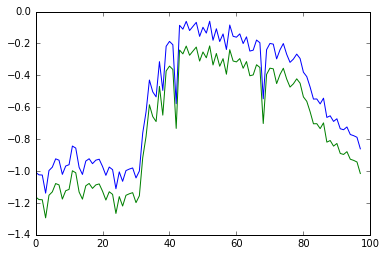

In [52]:
plt.plot(mfcc0.mean(1))
plt.plot(mfcc1.mean(1))

In [50]:
mfcc0.mean(1,keepdims=True).shape,mfcc0.shape

((98, 1), (98, 40))

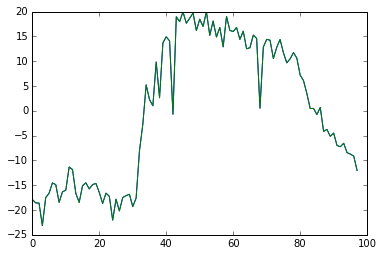

In [53]:
plt.plot((mfcc0-mfcc0.mean(0,keepdims=True)).sum(1))
plt.plot((mfcc1-mfcc1.mean(0,keepdims=True)).sum(1))

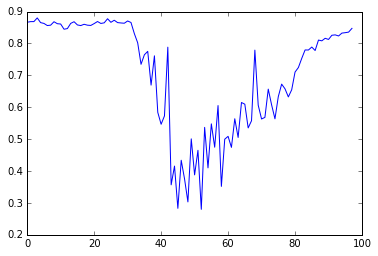

In [40]:
plt.plot(mfcc0.sum(1)/mfcc1.sum(1))

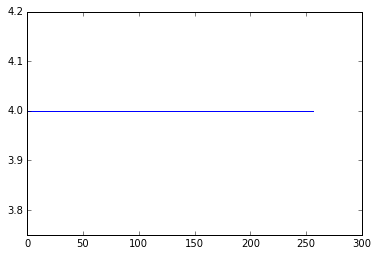

In [34]:
plt.plot(spect0.sum(0)/spect1.sum(0))

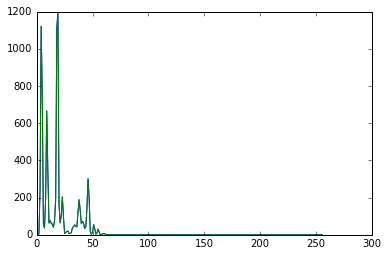

In [35]:
plt.plot(spect0.sum(0)/4 )
plt.plot(spect1.sum(0) )

(3, 1, 98, 257) 0


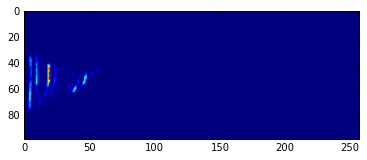

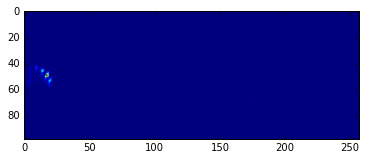

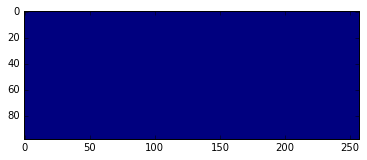

In [26]:
if 1:
    x1=soundfile.read("../input/train/audio/no/0132a06d_nohash_0.wav")[0]
    x2=soundfile.read("../input/train/audio/yes/0132a06d_nohash_0.wav")[0]
    with tf.Session() as sess:
        layer=SpectLayer()
        a=tf.placeholder('float32',[None, 16000])
        op=layer.call(a)
        xx=np.array([x1,x2, np.zeros_like(x1)])*.5
        b=sess.run(op,feed_dict={a:xx})
        print b.shape,np.isnan(b).sum()
        for arr in b:
            plt.imshow(np.squeeze(arr));plt.show()
             

(3, 1, 98, 257) 0


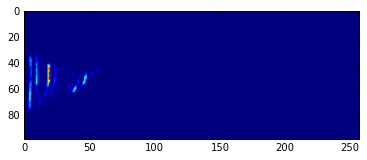

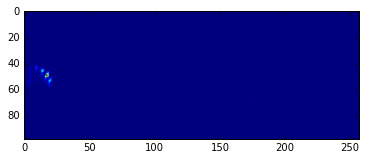

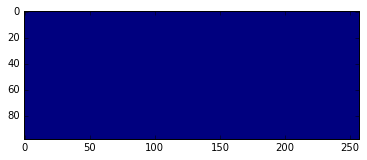

(3, 98, 40, 1) 0


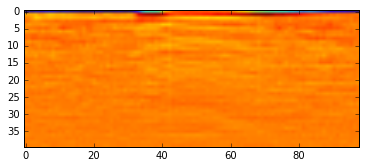

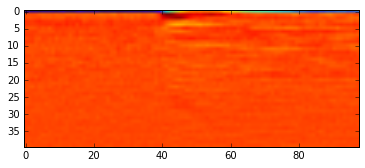

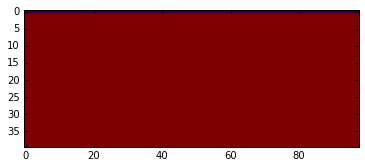

In [36]:
if 1:
    x1=soundfile.read("../input/train/audio/no/0132a06d_nohash_0.wav")[0]
    x2=soundfile.read("../input/train/audio/yes/0132a06d_nohash_0.wav")[0]
    with tf.Session() as sess:
        layer=SpectLayer()
        a=tf.placeholder('float32',[None, 16000])
        op=layer.call(a)
        xx=np.array([x1,x2, np.zeros_like(x1)])*0.5
        b=sess.run(op,feed_dict={a:xx})
        print b.shape,np.isnan(b).sum()
        for arr in b:
            plt.imshow(np.squeeze(arr));plt.show()
    with tf.Session() as sess:
        layer=MfcclLayer()
        a=tf.placeholder('float32',[None, 1, 98, 257])
        op=layer.call(a)
        b=sess.run(op,feed_dict={a:b})
        print b.shape,np.isnan(b).sum()
        for arr in b:
            plt.imshow(np.squeeze(arr).T);plt.show()            

In [14]:
def make_tf_cnv_model(input_shape = (16000,), output_num=12,dropout=0.5):
    model = Sequential()
    model.add(InputLayer(input_shape=input_shape))
    model.add(SpectLayer())    
    model.add(MfcclLayer())
    model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size=(8,20), padding='same' ))
    model.add(Activation("relu"))
    model.add(Dropout(rate=dropout))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2), padding='same'))
    
    
    model.add(Conv2D(64, kernel_size=(4,10), padding='same'))
    model.add(Activation("relu"))
    model.add(Dropout(rate=dropout))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2), padding='same'))
    
    model.add(Flatten())
    model.add(Dense(output_num))
    model.add(Activation('softmax'))
    return model

In [15]:
model=make_tf_cnv_model()

In [16]:
#SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))

In [17]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['categorical_accuracy'])

In [18]:
checkpoint = keras.callbacks.ModelCheckpoint("tf_cov2.h5", monitor='val_loss', 
                                             verbose=0, 
                                             save_best_only=True, 
                                             save_weights_only=False, mode='auto', period=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [19]:
model.fit_generator(generator=datagen.next_train(),
                        steps_per_epoch=600  ,
                        epochs=200,
                        validation_data=datagen.next_valid(),
                        validation_steps=100,
                        callbacks=[checkpoint, early_stopping] 
                   )

Epoch 1/200
loaded 6 noise files
loaded 51697 wave files
599/600 [============================>.] - ETA: 0s - loss: 1.1421 - categorical_accuracy: 0.6201loaded 6 noise files
loaded 6516 wave files
600/600 [==============================] - 209s 348ms/step - loss: 1.1413 - categorical_accuracy: 0.6205 - val_loss: 0.8187 - val_categorical_accuracy: 0.8274
Epoch 2/200
600/600 [==============================] - 194s 323ms/step - loss: 0.5135 - categorical_accuracy: 0.8358 - val_loss: 0.6916 - val_categorical_accuracy: 0.8567
Epoch 3/200
600/600 [==============================] - 194s 324ms/step - loss: 0.4108 - categorical_accuracy: 0.8691 - val_loss: 0.5525 - val_categorical_accuracy: 0.8868
Epoch 4/200
600/600 [==============================] - 194s 323ms/step - loss: 0.3590 - categorical_accuracy: 0.8847 - val_loss: 0.5161 - val_categorical_accuracy: 0.8973
Epoch 5/200
600/600 [==============================] - 194s 324ms/step - loss: 0.3237 - categorical_accuracy: 0.8952 - val_loss: 0.

In [20]:
m=keras.models.load_model("tf_cov2.h5",custom_objects={'MfcclLayer':MfcclLayer,'SpectLayer':SpectLayer})

In [21]:
dataset=datagen.testset
X,y=dataset.get_test_data()
pred=m.predict( np.array(X))
preddf=pd.DataFrame({'label':y, 'pred':list(pred)})
preddf['pred_label']=dataset.to_labels(preddf['pred'].map(lambda u: np.argmax(u) ))
print np.mean(preddf['label']==preddf['pred_label'])
confusion=pd.pivot_table(preddf,columns='label',index='pred_label',values='pred',aggfunc='count').fillna(0)
confusion=np.round(confusion/confusion.sum(0)*100,2)
display(confusion)

loaded 5920 wave files
loaded 6 noise files
0.887426447817


label        down     go   left     no    off     on  right  silence   stop  \
pred_label                                                                    
down        90.45   1.85   0.00   0.00   0.00   0.00   0.00      0.0   0.00   
go           2.01  92.59   0.00   1.49   0.00   0.48   0.00      0.0   1.47   
left         0.00   0.00  95.83   0.50   0.00   0.48   0.94      0.0   0.00   
no           2.51   1.85   0.00  95.05   0.00   0.00   0.00      0.0   0.00   
off          0.00   0.00   0.00   0.00  90.78   2.39   0.00      0.0   0.00   
on           0.00   0.00   0.00   0.00   0.00  91.39   0.00      0.0   0.49   
right        0.00   0.00   0.46   0.00   0.46   0.00  95.75      0.0   0.00   
silence      1.51   0.93   2.31   0.50   2.76   0.48   0.00    100.0   1.96   
stop         0.50   0.93   0.00   0.00   0.00   0.00   0.00      0.0  93.14   
unknown      2.51   1.39   0.46   1.49   1.38   3.35   3.30      0.0   0.49   
up           0.00   0.00   0.00   0.50   4.61   1.44   0.00      0.0   2.45   
yes          0.50   0.46   0.93   0.50   0.00   0.00   0.00      0.0   0.00   

label       unknown     up    yes  
pred_label                         
down           1.36   0.00   0.00  
go             2.19   0.99   0.00  
left           0.84   0.00   0.94  
no             0.70   0.00   0.47  
off            0.37   1.49   0.00  
on             0.73   0.00   0.00  
right          2.98   0.00   0.00  
silence        3.34   4.46   0.94  
stop           1.49   0.50   0.00  
unknown       84.75   0.99   2.82  
up             0.81  91.58   0.00  
yes            0.44   0.00  94.84

In [22]:
dataset=datagen.validset
X,y=dataset.get_test_data()
pred=m.predict( np.array(X))
preddf=pd.DataFrame({'label':y, 'pred':list(pred)})
preddf['pred_label']=dataset.to_labels(preddf['pred'].map(lambda u: np.argmax(u) ))
print np.mean(preddf['label']==preddf['pred_label'])
confusion=pd.pivot_table(preddf,columns='label',index='pred_label',values='pred',aggfunc='count').fillna(0)
confusion=np.round(confusion/confusion.sum(0)*100,2)
display(confusion)

0.884918401801


label        down     go   left     no    off     on  right  silence   stop  \
pred_label                                                                    
down        90.28   1.27   0.00   1.24   0.00   0.42   0.00      0.0   0.45   
go           1.62  91.14   0.00   3.32   0.41   0.42   0.44      0.0   0.00   
left         0.81   0.00  92.44   0.41   0.41   0.00   1.31      0.0   0.00   
no           2.43   2.53   0.00  92.12   0.00   0.00   0.00      0.0   0.00   
off          0.00   0.00   0.00   0.00  93.85   2.50   0.00      0.0   0.90   
on           0.00   0.00   0.00   0.00   0.00  90.83   0.00      0.0   0.00   
right        0.00   0.42   0.44   0.00   0.41   0.42  96.51      0.0   0.45   
silence      0.81   1.27   1.78   0.41   0.82   1.25   0.44    100.0   2.24   
stop         0.81   0.42   1.33   0.00   0.00   0.00   0.00      0.0  93.72   
unknown      2.83   2.53   1.33   1.66   0.41   3.75   1.31      0.0   0.45   
up           0.00   0.42   2.22   0.83   3.69   0.42   0.00      0.0   1.35   
yes          0.40   0.00   0.44   0.00   0.00   0.00   0.00      0.0   0.45   

label       unknown     up    yes  
pred_label                         
down           1.49   0.00   0.00  
go             2.26   1.30   0.42  
left           1.13   0.00   1.68  
no             0.94   0.43   1.26  
off            0.89   0.43   0.00  
on             0.48   0.00   0.00  
right          3.53   0.43   0.42  
silence        1.90   3.90   0.42  
stop           1.39   0.43   0.00  
unknown       84.38   0.87   0.00  
up             1.08  92.21   0.00  
yes            0.53   0.00  95.80

In [23]:
#make submission

In [24]:
sample=pd.read_csv('../input/sample_submission.csv')

In [25]:
idx_to_label={0: 'down', 1: 'go', 2: 'left', 3: 'no', 4: 'off', 5: 'on', 6: 'right', 7: 'silence', 8: 'stop', 9: 'unknown', 10: 'up', 11: 'yes'}

In [26]:
files=list(sample['fname'])
p=pool.Pool(8)
values=p.map(read_file ,["../input/test/audio/"+u for u in files])
p.close()
p.join()

In [27]:
pred=m.predict( np.array(values))

In [28]:
predlabels=[idx_to_label[u] for u in np.argmax(pred,1)]

In [29]:
sample['label']=predlabels

In [30]:
sample['label'].value_counts()

unknown    68851
silence    14397
right       9992
go          9208
left        8946
up          7655
no          7369
on          6943
off         6857
stop        6554
down        6114
yes         5652
Name: label, dtype: int64

In [47]:
sample['label'].value_counts()

unknown    64738
silence    13965
on         11851
yes         8959
left        8629
up          8318
stop        8013
down        7885
no          7488
off         6600
right       6070
go          6022
Name: label, dtype: int64

In [31]:
sample.head()

fname    label
0  clip_000044442.wav       no
1  clip_0000adecb.wav  unknown
2  clip_0000d4322.wav  unknown
3  clip_0000fb6fe.wav       up
4  clip_0001d1559.wav  unknown

In [32]:
sample.to_csv("../submission/keras_tfcovv3.csv.gz",compression='gzip',index=None)

In [57]:
sample=pd.read_csv("../submission/keras_tfcovv3.csv.gz")

In [58]:
sample.loc[sample['label']<>'yes','label']="NON_EXISTED"

In [59]:
sample['label'].value_counts()

NON_EXISTED    152886
yes              5652
Name: label, dtype: int64

In [60]:
sample.to_csv("../submission/keras_tfcovv3_yes.csv.gz",compression='gzip',index=None)

In [62]:
sample['label']='go'
sample.to_csv("../submission/go.csv.gz",compression='gzip',index=None)